# Estimating Randomized Benchmarking Fidelities #

## Introduction ##

This Notebook demonstrates how to use QInfer to the fidelity of a gateset using experimental data from randomized benchmarking.

## Setup ##

First, to make sure that this example works in both Python 2 and 3, we tell Python 2 to use 3-style division and printing.

In [1]:
from __future__ import division, print_function

Next, we import QInfer itself, along with NumPy and Matplotlib.

In [2]:
import qinfer as qi
import numpy as np
import matplotlib.pyplot as plt

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/qinfer/metrics.py:51: UserWarning: Could not import scikit-learn. Some features may not work.
  warnings.warn("Could not import scikit-learn. Some features may not work.")
/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/qinfer/parallel.py:53: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


For pretty-printing later, we'll need to borrow some unicode compatibility from ``future``, so that this notebook also works under Python 2. We'll also import ``reduce`` in a 2/3 compatible manner.

In [3]:
from future.utils import python_2_unicode_compatible
from builtins import str
from functools import reduce

We finish by configuring Matplotlib for plotting in Jupyter Notebook.

In [4]:
%matplotlib inline
try: plt.style.use('ggplot')
except: pass

## Randomized Benchmarking ##

In a randomized benchmarking (RB) experiment, one chooses a random sequence of gates from a 2-design (for example, the Clifford group), then inverts the ideal action of the sequence and measures if the inversion was successful.
Magesan *et al.* [10/tfz](https://dx.doi.org/10/tfz) showed that this results in an exponentially decay in the length $m$ of each sequence,
$$
    A p^m + B,
$$
where $p$ is related to the the average fidelity $F$ of the 2-design used by $F = 1 - (1 - p) (d - 1) / d$ for a $d$-dimensional system, and where $A$ and $B$ are nuisance parameters. We will give a more precise definition later, and will show a numerical example of how this model arises. For now, though, we will synthesize some data by assuming the correctness of the model.

In [5]:
p = 0.995
A = 0.5
B = 0.5

In [6]:
ms = np.linspace(1, 800, 201).astype(int)
signal = A * p ** ms + B

In [7]:
n_shots = 25
counts = np.random.binomial(p=signal, n=n_shots)

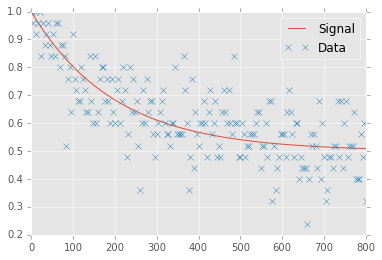

In [8]:
plt.plot(ms, signal, label='Signal')
plt.plot(ms, counts / n_shots, 'x', label='Data')
plt.ylim(ymax=1)
plt.legend()

## Analyzing RB Data ##

We can now pack our synthetic data up for analysis by **QInfer**.

In [9]:
data = np.column_stack([counts, ms, n_shots * np.ones_like(counts)])

In [10]:
mean, cov, extra = qi.simple_est_rb(data, return_all=True, n_particles=12000)
print("Estimated p: {:0.4f} ± {:0.4f}".format(mean[0], np.sqrt(cov[0, 0])))

Estimated p: 0.9925 ± 0.0020


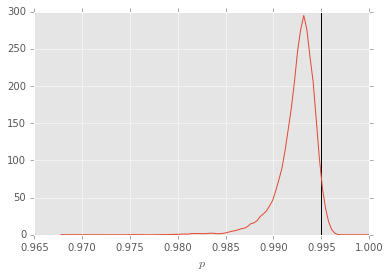

In [11]:
extra['updater'].plot_posterior_marginal(range_max=1)
plt.xlim(xmax=1)
ylim = plt.ylim(ymin=0)
plt.vlines(p, *ylim)
plt.ylim(*ylim);

Note that in analyzing, we have assumed that the true value of $p$ can be anything in the range $[0, 1]$, such that this will often underestimate the true fidelity. Including even a very modest assumption such as $p\ge 0.8$ can help dramatically.

In [12]:
mean, cov, extra = qi.simple_est_rb(data, return_all=True, n_particles=12000, p_min=0.8)
print("Estimated p: {:0.4f} ± {:0.4f}".format(mean[0], np.sqrt(cov[0, 0])))

Estimated p: 0.9958 ± 0.0010


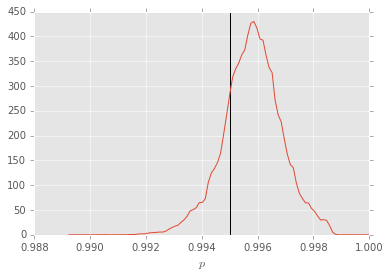

In [13]:
extra['updater'].plot_posterior_marginal(range_max=1)
plt.xlim(xmax=1)
ylim = plt.ylim(ymin=0)
plt.vlines(p, *ylim)
plt.ylim(*ylim);

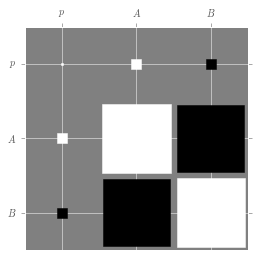

In [14]:
extra['updater'].plot_covariance()

In [15]:
extra['updater']

$p$,$A$,$B$
$1.00 \pm 0.00$,$0.5 \pm 0.0$,$0.5 \pm 0.0$


## [Advanced] RB With Gate-Level Simulation ##

We can also synthesize data by simulating gates, instead of assuming the correctness of the Magesan *et al.* model *a priori*. We will do so here using QuTiP. Let's start by modeling each gate $S_i$ as the ideal unitary followed by a gate-independent noise channel, $S_i = \Lambda U_i$. We will take $\Lambda = e^{-0.08i \sigma_x}$ to demonstrate that the RB model arises even when the noise is purely unitary, so long as the noise remains gate- and time-independent.

In [16]:
import qutip as qt
from operator import mul

In [17]:
lambda_ = qt.to_super((-1j * 0.08 * qt.sigmax()).expm())
lambda_

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False
Qobj data =
[[ 0.99361364+0.j         0.00000000-0.0796591j  0.00000000+0.0796591j
   0.00638636+0.j       ]
 [ 0.00000000-0.0796591j  0.99361364+0.j         0.00638636+0.j
   0.00000000+0.0796591j]
 [ 0.00000000+0.0796591j  0.00638636+0.j         0.99361364+0.j
   0.00000000-0.0796591j]
 [ 0.00638636+0.j         0.00000000+0.0796591j  0.00000000-0.0796591j
   0.99361364+0.j       ]]

The value of $p$ for this gate then serves as the true value that we are attempting to learn:

In [18]:
qi.rb.p(qt.average_gate_fidelity(lambda_))

0.99148485558375188

For simplicity, we'll take the preparation and measurement to be perfect— because this assumption is represented as a pair of QuTiP Qobj instances, it's easy to change. 

In [19]:
rho = qt.ket2dm(qt.basis(2, 0))
meas = rho

For standard randomized benchmarking, however, we need to do a bit more work, since the ideal action of each sequence must be the identity. In particular, we need to be able to quickly find which gate we need to add to the end of each sequence to invert the previous gates.

To do so, we will lean heavily on the presentation of the Clifford group used in the [**newsynth**](http://hackage.haskell.org/package/newsynth-0.3.0.2) Haskell package by Ross and Selinger.

### Clifford Presentation as $\mathbb{Z}_3 \times \mathbb{Z}_2 \times \mathbb{Z}_4 \times \mathbb{Z}_8$ ###

In [20]:
from itertools import product

Following the **newsynth** approach, we will represent each single-qubit Clifford gate $U$ by a tuple of integers $(i, j, k, l)$ such that
$$
    (i, j, k, l) \mapsto \omega^l E^i X^j S^k,
$$
where $S = \operatorname{diag}(1, i)$, $X = \sigma_x = \left(\begin{matrix}0&1\\1&0\end{matrix}\right)$, $\omega = e^{2 \pi i /
8}$, $H = \left(\begin{matrix}1&1\\1&-1\end{matrix}\right) / \sqrt{2}$ is the Hadamard gate, and where $E = H S^3 \omega^3$. This is a convienent presentation, as $\omega^8 = 1$ and $E^3 = X^2 = S^4 = \mathbb{1}$, such that each element of $\mathbb{Z}_3 \times \mathbb{Z}_2 \times \mathbb{Z}_4 \times \mathbb{Z}_8$ represents exactly one single-qubit Clifford gate. This in turn makes it very convienent to randomly select Clifford group elements without having to worry that we have double-counted any gates due to our presentation.

In [21]:
w = np.exp(1j * 2 * np.pi / 8)
H = qt.snot()

X = qt.sigmax()
S = qt.phasegate(np.pi / 2)
E = H * (S ** 3) * w ** 3

We'll port the **newsynth** presentation to Python by subclassing ``tuple`` with methods that implement multiplication and inversion, and that return an ordinary QuTiP ``Qobj`` representing each gate. These methods will depend on three lookup tables that represent the commutation relatons between the generators $E$, $X$ and $S$. First, we implement the **newsynth** table $(k, j) \mapsto (k', l')$ such that $X^j S^k = S^{k'} X^j \omega^{l'}$. This table will let us commute $X$ past $S$ in products.

In [22]:
CLIFFORD_SX = {
    (0, 0): (0,0),
    (0, 1): (0,0),
    (1, 0): (1,0),
    (1, 1): (3,2),
    (2, 0): (2,0),
    (2, 1): (2,4),
    (3, 0): (3,0),
    (3, 1): (1,6),
}

In [23]:
for k, j in product(range(4), range(2)):
    kp, lp = CLIFFORD_SX[k, j]
    assert (
        X**j * S**k -
        S**kp * X**j * w**lp
    ).norm() <= 1e-8

Next, we'll implement the table $(j, k, i) \mapsto (i', j', k', l')$ such that $X^j S^k E^i = E^{i'} X^{j'} S^{k'} \omega^{l'}$. This will let us commute $E$ into its proper position.

In [24]:
CLIFFORD_XSE = {
    (0, 0, 0): (0,0,0,0),
    (0, 0, 1): (1,0,0,0),
    (0, 0, 2): (2,0,0,0),
    (0, 1, 0): (0,0,1,0),
    (0, 1, 1): (2,0,3,6),
    (0, 1, 2): (1,1,3,4),
    (0, 2, 0): (0,0,2,0),
    (0, 2, 1): (1,1,2,2),
    (0, 2, 2): (2,1,0,0),
    (0, 3, 0): (0,0,3,0),
    (0, 3, 1): (2,1,3,6),
    (0, 3, 2): (1,0,1,2),
    (1, 0, 0): (0,1,0,0),
    (1, 0, 1): (1,0,2,0),
    (1, 0, 2): (2,1,2,2),
    (1, 1, 0): (0,1,1,0),
    (1, 1, 1): (2,1,1,0),
    (1, 1, 2): (1,1,1,0),
    (1, 2, 0): (0,1,2,0),
    (1, 2, 1): (1,1,0,6),
    (1, 2, 2): (2,0,2,6),
    (1, 3, 0): (0,1,3,0),
    (1, 3, 1): (2,0,1,4),
    (1, 3, 2): (1,0,3,2),
}

In [25]:
for j, k, i in product(range(2), range(4), range(3)):
    ip, jp, kp, lp = CLIFFORD_XSE[j, k, i]
    assert (
        X**j * S**k * E**i -
        E**ip * X**jp * S**kp * w**lp
    ).norm() <= 1e-8

The last table we will need is $(i, j, k) \mapsto (i', j', k', l')$ such that $(E^i S^j X^k)^{-1} = E^{i'} S^{j'} X^{k'} \omega^{l'}$. That is, the table that stores the inverse of each Clifford gate with phase $l = 0$.

In [26]:
CLIFFORD_INV = {
    (0, 0, 0): (0,0,0,0),
    (0, 0, 1): (0,0,3,0),
    (0, 0, 2): (0,0,2,0),
    (0, 0, 3): (0,0,1,0),
    (0, 1, 0): (0,1,0,0),
    (0, 1, 1): (0,1,1,6),
    (0, 1, 2): (0,1,2,4),
    (0, 1, 3): (0,1,3,2),
    (1, 0, 0): (2,0,0,0),
    (1, 0, 1): (1,0,1,2),
    (1, 0, 2): (2,1,0,0),
    (1, 0, 3): (1,1,3,4),
    (1, 1, 0): (2,1,2,2),
    (1, 1, 1): (1,1,1,6),
    (1, 1, 2): (2,0,2,2),
    (1, 1, 3): (1,0,3,4),
    (2, 0, 0): (1,0,0,0),
    (2, 0, 1): (2,1,3,6),
    (2, 0, 2): (1,1,2,2),
    (2, 0, 3): (2,0,3,6),
    (2, 1, 0): (1,0,2,0),
    (2, 1, 1): (2,1,1,6),
    (2, 1, 2): (1,1,0,2),
    (2, 1, 3): (2,0,1,6),
}

In [27]:
for i, j, k in product(range(3), range(2), range(4)):
    ip, jp, kp, lp = CLIFFORD_INV[i, j, k]
    assert (
        (E**i * X**j * S**k).dag() -
        E**ip * X**jp * S**kp * w**lp
    ).norm() <= 1e-8

We are now equipped to represent each element of the Ross and Selinger presentation as an instance of a new class ``Clifford``. By overriding ``Clifford.__new__``, we can ensure that exactly one instance is created for each combination of $i$, $j$, $k$ and $l$. This will effectively let us lazily compute the different properties of each gate, making it much faster to sample each sequence.

In [28]:
sup_numerals = u"⁰¹²³⁴⁵⁶⁷⁸⁹"

In [29]:
@python_2_unicode_compatible
class Clifford(tuple):
    
    # Maintain a dictionary of which Clifford instances already
    # exist, so that __new__ can return such existing instances.
    __instances = {}    
    
    def __new__ (cls, i=0, j=0, k=0, l=0):
        if (i, j, k, l) in cls.__instances:
            return cls.__instances[i, j, k, l]
        else:
            new = super(Clifford, cls).__new__(cls, (i % 3, j % 2, k % 4, l % 8))
            cls.__instances[i, j, k, l] = new
            return new
    
    # Lazily store the QuTiP representation of each gate.
    _Q = None  
    
    def __mul__(self, other):
        """
        Returns the product of this Clifford gate with another one.
        """
        
        # Unpack the powers of E, S, X and omega for each gate.
        i1, j1, k1, l1 = self
        i2, j2, k2, l2 = other
        
        # Commute E^i₂ past X^j₁ S^k₁.
        i3, j3, k3, l3 = CLIFFORD_XSE[j1, k1, i2]
        
        # Commute S past X.
        k4, l4 = CLIFFORD_SX[k3, j2]
        
        return Clifford(
            i1 + i3,
            j3 + j2,
            k4 + k2,
            # Accumulate the phases we picked up at each step.
            l4 + l3 + l1 + l2
        )
    @property
    def inv(self):
        (i2, j2, k2, l2) = CLIFFORD_INV[self[0], self[1], self[2]]
        return Clifford(
            i2, j2, k2, l2 - self[3]
        )
    
    def qobj(self):
        if not self._Q:
            self._Q = E**self[0] * X**self[1] * S**self[2] * w**self[3]
        return self._Q
    
    # Finally, we'll add some support for pretty-printing.
    
    def __repr__(self):
        return u"Clifford({0[0]}, {0[1]}, {0[2]}, {0[3]})".format(self)
    
    def __str__(self):
        if self[3] >= 4:
            return u"-" + str(Clifford(self[0], self[1], self[2], self[3] % 4))
        elif self[3] >= 2:
            return u"i" + str(Clifford(self[0], self[1], self[2], self[3] % 2))
        elif self[3] == 1:
            return u"ω" + str(Clifford(self[0], self[1], self[2]))
        elif self == Clifford(0, 0, 0, 0):
            return u"𝟙"
        else:
            return u"".join([
                u"{}{}".format(U, sup_numerals[power] if power > 1 else u"")
                for U, power in zip(u"EXS", self[:3])
                if power
            ])


In [30]:
clifford_group = [
    Clifford(i, j, k, l)
    for i, j, k, l in
    product(range(3), range(2), range(4), range(8))
]

In [31]:
print(", ".join(map(str, clifford_group)))

𝟙, ω𝟙, i𝟙, iω𝟙, -𝟙, -ω𝟙, -i𝟙, -iω𝟙, S, ωS, iS, iωS, -S, -ωS, -iS, -iωS, S², ωS², iS², iωS², -S², -ωS², -iS², -iωS², S³, ωS³, iS³, iωS³, -S³, -ωS³, -iS³, -iωS³, X, ωX, iX, iωX, -X, -ωX, -iX, -iωX, XS, ωXS, iXS, iωXS, -XS, -ωXS, -iXS, -iωXS, XS², ωXS², iXS², iωXS², -XS², -ωXS², -iXS², -iωXS², XS³, ωXS³, iXS³, iωXS³, -XS³, -ωXS³, -iXS³, -iωXS³, E, ωE, iE, iωE, -E, -ωE, -iE, -iωE, ES, ωES, iES, iωES, -ES, -ωES, -iES, -iωES, ES², ωES², iES², iωES², -ES², -ωES², -iES², -iωES², ES³, ωES³, iES³, iωES³, -ES³, -ωES³, -iES³, -iωES³, EX, ωEX, iEX, iωEX, -EX, -ωEX, -iEX, -iωEX, EXS, ωEXS, iEXS, iωEXS, -EXS, -ωEXS, -iEXS, -iωEXS, EXS², ωEXS², iEXS², iωEXS², -EXS², -ωEXS², -iEXS², -iωEXS², EXS³, ωEXS³, iEXS³, iωEXS³, -EXS³, -ωEXS³, -iEXS³, -iωEXS³, E², ωE², iE², iωE², -E², -ωE², -iE², -iωE², E²S, ωE²S, iE²S, iωE²S, -E²S, -ωE²S, -iE²S, -iωE²S, E²S², ωE²S², iE²S², iωE²S², -E²S², -ωE²S², -iE²S², -iωE²S², E²S³, ωE²S³, iE²S³, iωE²S³, -E²S³, -ωE²S³, -iE²S³, -iωE²S³, E²X, ωE²X, iE²X, iωE²X, -E²X, -ωE²X, -iE

Now that we can sample, multiply and invert Clifford gates efficiently, we have everything we need to define *sequences* of Cliffords. We will do so in terms of a gateset that defines the noisy implementation of each Clifford gate. For this example, we will hold to the traditional RB assumptions and the same noise channel $\Lambda$ after the ideal action of each gate.

In [32]:
gateset = {
    gate: lambda_ * qt.to_super(gate.qobj())
    for gate in clifford_group
}

To form a sequence, we pick gates at random from the Clifford group, then append the inverse gate to the end.

In [33]:
def seq(m, gateset):
    gates = [clifford_group[idx] for idx in np.random.randint(len(clifford_group), size=m)]
    inv_gate = reduce(mul, reversed(gates)).inv
    gates = [inv_gate] + list(gates)
    return reduce(mul, [
        gateset[gate] for gate in reversed(gates)
    ])

In [34]:
seq(100, gateset)

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False
Qobj data =
[[ 0.75637527+0.j         -0.30459068-0.30248345j -0.30459068+0.30248345j
   0.24362473+0.j        ]
 [ 0.35180016-0.24598449j  0.74524982+0.12925265j -0.04329705+0.23974649j
  -0.35180016+0.24598449j]
 [ 0.35180016+0.24598449j -0.04329705-0.23974649j  0.74524982-0.12925265j
  -0.35180016-0.24598449j]
 [ 0.24362473+0.j          0.30459068+0.30248345j  0.30459068-0.30248345j
   0.75637527+0.j        ]]

In [35]:
def sample_rb_datum(m, gateset, rho, meas):
    S = seq(m, gateset)
    pr = (
        qt.operator_to_vector(meas).dag() * S * qt.operator_to_vector(rho)
    )[0, 0]
    return 1 if np.random.random() < pr else 0

In [36]:
counts = np.empty_like(ms)
progbar = qi.IPythonProgressBar()
progbar.start(ms.sum())
progress = 0

for idx, m in enumerate(ms):
    progbar.description = u'𝑚 = {}...'.format(m)
    counts[idx] = sum([
        sample_rb_datum(m, gateset, rho, meas)
        for _ in range(n_shots)
    ])
    progress += m
    progbar.update(progress)

In [37]:
data = np.column_stack([counts, ms, n_shots * np.ones_like(counts)])
mean, cov, extra = qi.simple_est_rb(data, return_all=True, n_particles=12000, p_min=0.8)
print("Estimated p: {:0.4f} ± {:0.4f}".format(mean[0], np.sqrt(cov[0, 0])))
print("Estimated A: {:0.4f} ± {:0.4f}".format(mean[1], np.sqrt(cov[1, 1])))
print("Estimated B: {:0.4f} ± {:0.4f}".format(mean[2], np.sqrt(cov[2, 2])))

Estimated p: 0.9911 ± 0.0017
Estimated A: 0.4432 ± 0.0261
Estimated B: 0.5063 ± 0.0118


In the Magesan *et al.* model, $A$ and $B$ are defined as
\begin{align*}
    A & \mathrel{:=} \operatorname{Tr}(E \Lambda(\rho - \mathbb{1} / d)) \textrm{ and} \\
    B & \mathrel{:=} \operatorname{Tr}(E \Lambda(\mathbb{1} / d)),
\end{align*}
where $d$ is the dimension of the system (in this case, 2). By using our description of $\Lambda$, $\rho$ and $E$, we can calculate these parameters and plot the "true" model for our data, along side the data and our reconstruction from the estimated values of $p$, $A$ and $B$.

In [38]:
A = (qt.operator_to_vector(meas).dag() * lambda_ * qt.operator_to_vector(rho - qt.qeye(2) / 2))[0, 0]
B = (qt.operator_to_vector(meas).dag() * lambda_ * qt.operator_to_vector(qt.qeye(2) / 2))[0, 0]

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


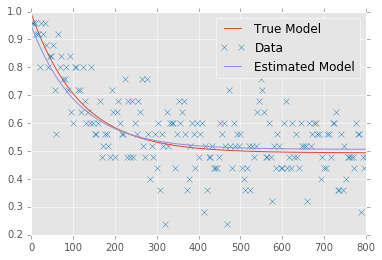

In [39]:
plt.plot(ms, A + B * qi.rb.p(qt.average_gate_fidelity(lambda_)) ** ms, label='True Model')
plt.plot(ms, counts / n_shots, 'x', label='Data')
plt.plot(ms, mean[2] + mean[1] * mean[0] ** ms, label='Estimated Model')
plt.legend()

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


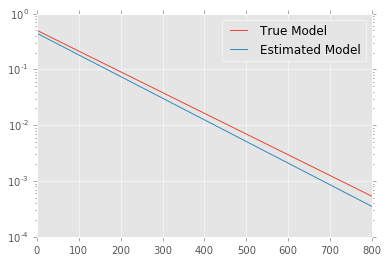

In [40]:
plt.semilogy(ms, B * qi.rb.p(qt.average_gate_fidelity(lambda_)) ** ms, label='True Model')
# plt.plot(ms, (counts / n_shots) - mean[1], 'x', label='Data')
plt.semilogy(ms, mean[1] * mean[0] ** ms, label='Estimated Model')
plt.legend()

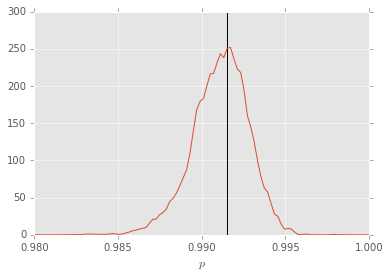

In [41]:
extra['updater'].plot_posterior_marginal(range_max=1)
plt.xlim(xmax=1)
ylim = plt.ylim(ymin=0)
plt.vlines(qi.rb.p(qt.average_gate_fidelity(lambda_)), *ylim)
plt.ylim(*ylim);

We can also look at the posterior marginal distributions over each of $A$ and $B$.

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


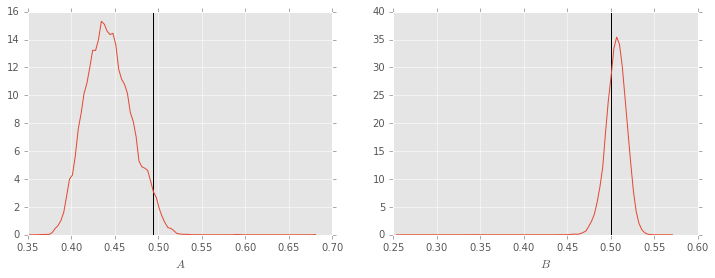

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
extra['updater'].plot_posterior_marginal(idx_param=1)
ylim = plt.ylim(ymin=0)
plt.vlines(A, *ylim)
plt.ylim(*ylim);

plt.subplot(1, 2, 2)
extra['updater'].plot_posterior_marginal(idx_param=2)
ylim = plt.ylim(ymin=0)
plt.vlines(B, *ylim)
plt.ylim(*ylim);

Finally, we can plot the covariance matrix for all three parameters, showing how our uncertianty about each of the parameters $p$, $A$ and $B$ are correlated. We do so as a [Hinton diagram](http://tonysyu.github.io/mpltools/auto_examples/special/plot_hinton.html), in which each positive element is plotted as a white square while each negative element is plotted as a black square. The respective sizes of each element show their magnitudes. That we see a large black square in the $(A, B)$ and $(B, A)$ matrix elements tells us that the estimates of $A$ and $B$ are strongly anti-correlated, such that learning about one tells us a lot about the other.

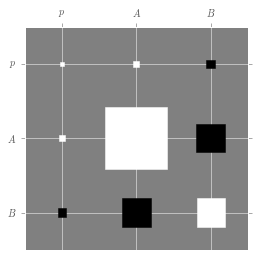

In [43]:
extra['updater'].plot_covariance()

This becomes more obvious if we plot the correlation matrix instead, where each matrix element is rescaled as $\operatorname{Corr}(X, Y) = \operatorname{Cov}(X, Y) / \sqrt{\operatorname{Cov}(X, X) \operatorname{Cov}(Y, Y)}$.

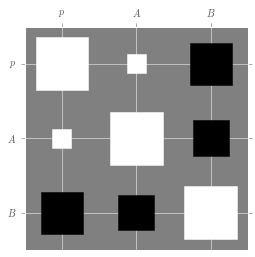

In [44]:
extra['updater'].plot_covariance(corr=True)

This shows that improving our knowledge of $B$ can have a large impact on our uncertianty in $p$.

## Custom Priors and Updater Loop ##

We can exploit this by providing a prior distribution that is relatively certain about the values of $A$ and $B$. Such a prior can be justified, for instance, by other experiments that demonstrate high-fidelity measurements. In this example, we will assume a prior distribution over $A$ and $B$ that is narrowly centered around the true values to demonstrate the utility of prior information.

Instead of using ``simple_est_rb``, we'll use ``RandomizedBenchmarkingModel`` directly, and then wrapping this model with a ``BinomialModel`` to describe multiple shots.

In [45]:
model = qi.BinomialModel(qi.RandomizedBenchmarkingModel())

We can then use ``PostselectedDistribution`` to ensure that our prior is always valid for randomized benchmarking.

In [46]:
prior = qi.PostselectedDistribution(
    qi.ProductDistribution(
        qi.UniformDistribution([0.8, 1]),
        qi.MultivariateNormalDistribution(
            np.array([0.498, 0.499]),
            np.diag([0.004, 0.002]) ** 2
        )
    ),
    model
)

Next, we'll set up an updater to consume the data we simulated in the previous section.

In [47]:
updater = qi.smc.SMCUpdater(model, 12000, prior)

We then setup arrays to hold our outcomes and our experiment parameters.

In [48]:
outcomes = np.array(counts, dtype='uint')[:, np.newaxis]
expparams = np.empty(outcomes.shape, dtype=model.expparams_dtype)
expparams['n_meas'] = n_shots
expparams['m'][:, 0] = ms

Finally, we can update our prior with the data to find the posterior distribution.

In [49]:
for outcome, experiment in zip(outcomes, expparams):
    updater.update(outcome, experiment)

In [50]:
mean = updater.est_mean()
cov = updater.est_covariance_mtx()

In [51]:
print("Estimated p: {:0.4f} ± {:0.4f}".format(mean[0], np.sqrt(cov[0, 0])))
print("Estimated A: {:0.4f} ± {:0.4f}".format(mean[1], np.sqrt(cov[1, 1])))
print("Estimated B: {:0.4f} ± {:0.4f}".format(mean[2], np.sqrt(cov[2, 2])))

Estimated p: 0.9916 ± 0.0006
Estimated A: 0.4950 ± 0.0031
Estimated B: 0.4987 ± 0.0019


/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


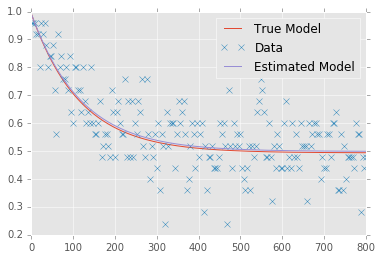

In [52]:
plt.plot(ms, A + B * qi.rb.p(qt.average_gate_fidelity(lambda_)) ** ms, label='True Model')
plt.plot(ms, counts / n_shots, 'x', label='Data')
plt.plot(ms, mean[2] + mean[1] * mean[0] ** ms, label='Estimated Model')
plt.legend()

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


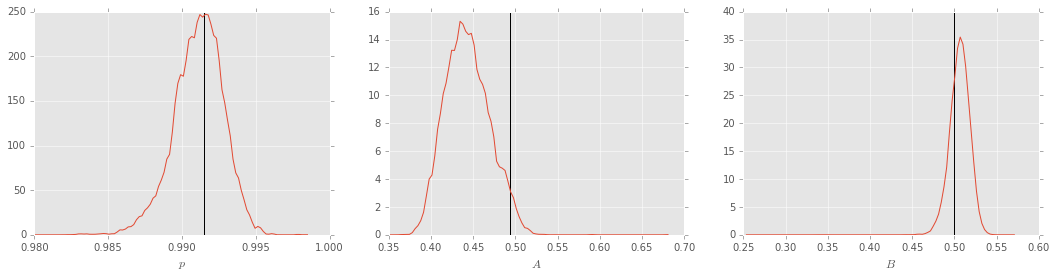

In [53]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
extra['updater'].plot_posterior_marginal(idx_param=0)
ylim = plt.ylim(ymin=0)
plt.vlines(qi.rb.p(qt.average_gate_fidelity(lambda_)), *ylim)
plt.ylim(*ylim);


plt.subplot(1, 3, 2)
extra['updater'].plot_posterior_marginal(idx_param=1)
ylim = plt.ylim(ymin=0)
plt.vlines(A, *ylim)
plt.ylim(*ylim);

plt.subplot(1, 3, 3)
extra['updater'].plot_posterior_marginal(idx_param=2)
ylim = plt.ylim(ymin=0)
plt.vlines(B, *ylim)
plt.ylim(*ylim);

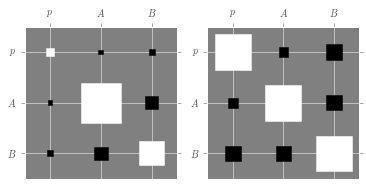

In [54]:
plt.subplot(1, 2, 1)
updater.plot_covariance()

plt.subplot(1, 2, 2)
updater.plot_covariance(corr=True)